# Evaluating results and Analysis (after training a model)
- Use this notebook to evaluate flourescence images predictions for a certain organelle
- insert the path prefix for the github directory in "main_path"
- you need flourescence predictions and ground truth folders to be under "data"
- choose the organelle to predict
- choose how many patches from the BF folder you want to predict


In [1]:
main_path = "/home/odedrot/In_silico_labelling_BF/Github/" ## change to main directory of github
organelle = 'NucEnv' # # NucEnv , Nuclioli , DNAmito , ER , AF , Mito , Membrane , Micro , TJ
Nimgs = 5 ## how many patches to load

In [10]:
import skimage
from skimage.metrics import hausdorff_distance
from skimage.feature import hog

import scipy
from scipy import ndimage
from scipy.spatial.distance import jensenshannon
from scipy.ndimage import distance_transform_edt, label
import scipy.stats as stats
# from scipy.ndimage import measurements
# from scipy.stats import spearmanr, skew, kurtosis 
from glrlm import GLRLM


import torch
from torch.optim import AdamW
from torch.autograd import Function
from torch import einsum
from torch.fft import fft2, ifft2
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils import data
import torch.nn.functional as F
from torchvision.models import vgg16
import torchvision.transforms as torch_transforms
from torchvision import utils as vutils
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import cv2 
import random
import pandas as pd

sys.path.append(main_path+'src')
from ProcessingFunctions import segmentation_pipeline, seg_metrics, get_markers_measurements, make_contours_from_segmentation
from Params import SegmentationParams
from DisplayFunctions import display_images, volumetric2sequence
from MetricsFunctions import lpips, glcm_measurements, pcc, mse, jsd, mi, ms_ssim
from LoadSaveFunctions import load_patches
from generative.metrics import FIDMetric, MMDMetric, MultiScaleSSIMMetric, SSIMMetric


In [3]:
# initialize parameters and gpu

seg_params = SegmentationParams(organelle)
device = torch.device("cuda") 

In [4]:
BF_images                = load_patches(main_path, organelle, 'BF', Nimgs) # (5, 16, 64, 64) 0-1
GT_images                = load_patches(main_path, organelle, 'GT', Nimgs) # (5, 16, 64, 64)
Unet_images              = load_patches(main_path, organelle, 'Unet', Nimgs) # (5, 16, 64, 64)
GAN_images               = load_patches(main_path, organelle, 'GAN', Nimgs) # (5, 16, 64, 64)
DDPM_images              = load_patches(main_path, organelle, 'FL_pred', Nimgs) # (5, 16, 64, 64)
DDPMavg_images           = load_patches(main_path, organelle, 'FLavg_pred', Nimgs) # (5, 16, 64, 64)
seg_images       = load_patches(main_path, organelle, 'FLavg_std_seg', Nimgs)       # (5, 16, 64, 64) 
seg_seeds_images = load_patches(main_path, organelle, 'FLavg_std_seg_seeds', Nimgs) # (5, 16, 64, 64)
rn=4

In [5]:
if organelle == 'NucEnv':
    remove = [] # [95, 111,  88,  12] # 
    organelle_th = -2 
    filter_type = 'median' # 'bilateral' 'median'
    filter_kernel = 3
    sigma = 70 # for bilateral
    do_morph=False
    k1,k2,k3 = 3,3,3
    do_erode_dilate=False
    do_remove_small_objects=False
    do_fill_holes=False
    do_fill_holes_boarders=False

if organelle == 'Micro':
    remove = [] 
    organelle_th = -2 # 'NucEnv' - 20  ,  'Nuclioli' - 65
    filter_type = 'median' # 'bilateral' 'median'
    filter_kernel = 3
    sigma = 15 # 15
    do_morph = False
    k1,k2,k3 = 3,3,3
    
if organelle == 'AF':
    remove = [] 
    organelle_th = -2 # 'NucEnv' - 20  ,  'Nuclioli' - 65
    filter_type = 'median' # 'bilateral' 'median'
    filter_kernel=3
    sigma=15 # 15
    do_morph=False
    k1,k2,k3 = 3,3,3
   
if organelle == 'Mito':
    remove = [] 
    organelle_th = -2 # 'NucEnv' - 20  ,  'Nuclioli' - 65
    filter_type = 'median' # 'bilateral' 'median'
    filter_kernel=3
    sigma=50
    do_morph=False
    k1,k2,k3 = 3,3,3
    
if organelle == 'DNAmito':
    remove = []  
    organelle_th = -2 # 'NucEnv' - 20  ,  'Nuclioli' - 65
    filter_type = 'median' # 'bilateral' 'median'
    filter_kernel=5
    sigma=50
    do_morph=False
    k1,k2,k3 = 3,3,3
    
    
if organelle == 'Nuclioli':
    remove = []
    organelle_th = -2 # 'NucEnv' - 20  ,  'Nuclioli' - 65
    filter_type = 'median' # 'bilateral' 'median'
    filter_kernel = 3 #  ALL-7, Mito-9
    sigma = 50 # 
    do_morph=True
    k1,k2,k3 = 3,3,3

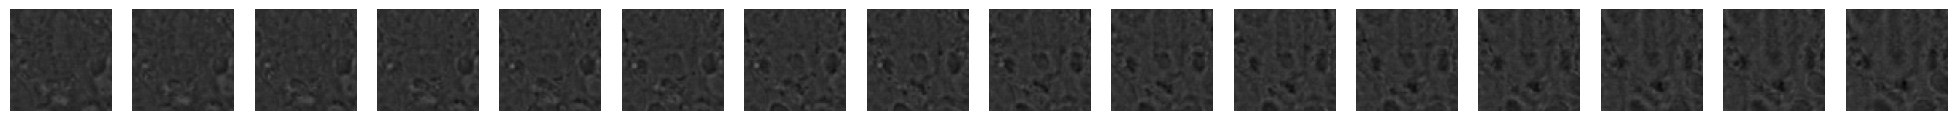

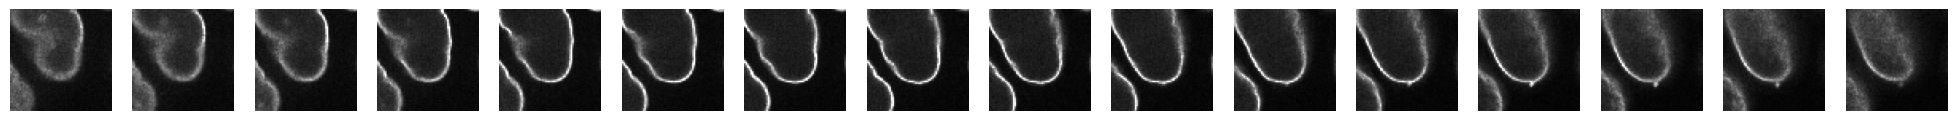

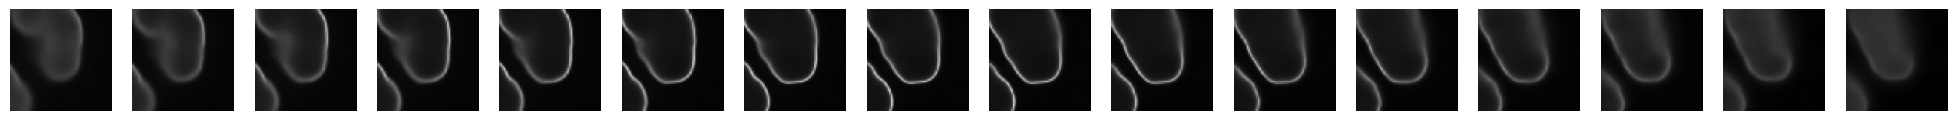

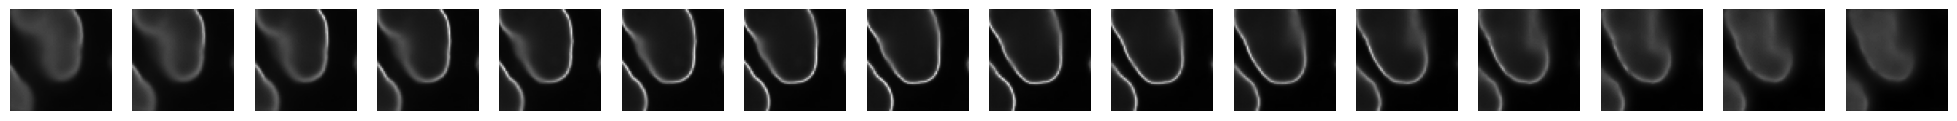

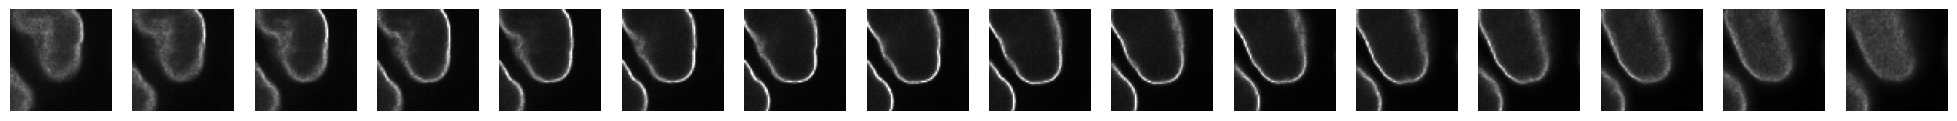

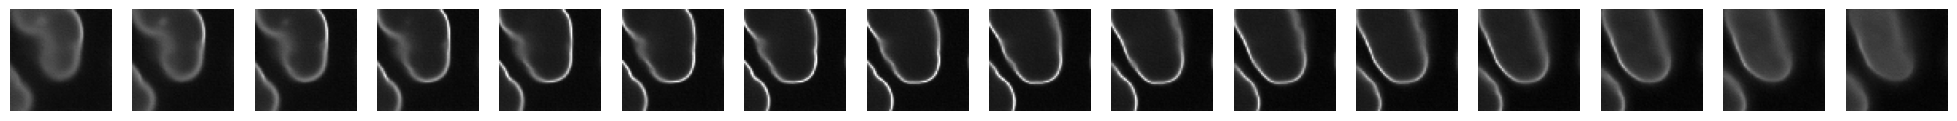

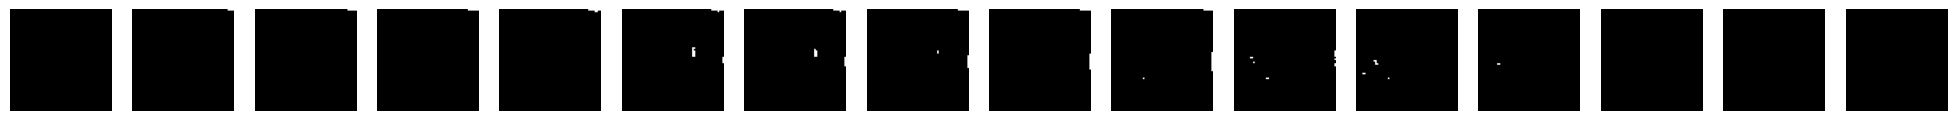

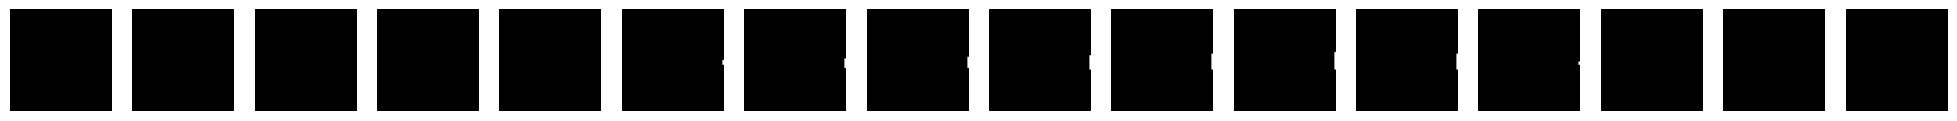

In [6]:
id= 0
display_images(BF_images[id]  , 1,BF_images[0].shape[0], range(BF_images[0].shape[0]), show_labels='False', vmin=0, vmax=1)
display_images(GT_images[id]  , 1,BF_images[0].shape[0], range(BF_images[0].shape[0]), show_labels='False', vmin=0, vmax=1)
display_images(Unet_images[id]  , 1,BF_images[0].shape[0], range(BF_images[0].shape[0]), show_labels='False', vmin=0, vmax=1)
display_images(GAN_images[id]  , 1,BF_images[0].shape[0], range(BF_images[0].shape[0]), show_labels='False', vmin=0, vmax=1)
display_images(DDPM_images[id]  , 1,BF_images[0].shape[0], range(BF_images[0].shape[0]), show_labels='False', vmin=0, vmax=1)
display_images(DDPMavg_images[id]  , 1,BF_images[0].shape[0], range(BF_images[0].shape[0]), show_labels='False', vmin=0, vmax=1)
display_images(seg_images[id]  , 1,BF_images[0].shape[0], range(BF_images[0].shape[0]), show_labels='False', vmin=0, vmax=1)
display_images(seg_seeds_images[id]  , 1,BF_images[0].shape[0], range(BF_images[0].shape[0]), show_labels='False', vmin=0, vmax=1)

In [7]:
def z_norm(data):
    return data # (data - data.mean())  / (data.std() + 0.0001)

def minmax_norm(data):
    return data # (data - data.min())  / (data.max() - data.min())

def pcc(imgs1, imgs2, rn=3):
    return np.round( stats.pearsonr( imgs1.flatten() , imgs2.flatten() )[0], rn)

def mse(imgs1, imgs2, rn=3):
    return np.round( np.mean(np.abs( imgs1.flatten() - imgs2.flatten() )**2), rn)

def ms_ssim(imgs1, imgs2, rn=3):
    return np.round( MultiScaleSSIMMetric(spatial_dims=2, data_range=1.0, kernel_size=4)( torch.tensor(imgs1), torch.tensor(imgs2) ).mean().numpy(), rn)

def jsd(imgs1, imgs2, rn=3):
    return np.round( jensenshannon( imgs1.flatten(), imgs2.flatten(), base=2 ), rn)

def mi(imgs1, imgs2, rn=3, bins=20):
    eps = 0.000000000001
    hgram, x_edges, y_edges = np.histogram2d( imgs1.ravel(),imgs2.ravel(), bins=bins)
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    Hx = -np.sum( px*np.log2(px+eps) ) # scalar  -np.sum( joint_prob_mat.sum(axis=1) * np.log2(joint_prob_mat.sum(axis=1)+eps) )
    Hy = -np.sum( py*np.log2(py+eps) ) # scalar  -np.sum( joint_prob_mat.sum(axis=0) * np.log2(joint_prob_mat.sum(axis=0)+eps) )
    Hxy = -np.sum(pxy * np.log2(pxy+eps)) 
    mi = Hx + Hy - Hxy
    return np.round(mi, rn) 

def run_filter(img3D, filter_kernel = 5, sigma = 50, filter_type='median'): # should be 0-255 uint8
    img3D = img3D.astype('uint8') # 16,64,64
    ### denoising filter 
    img3D_denoised = []
    for i in range(img3D.shape[0]):
        if filter_type == 'median':
            # img3D_denoised.append( cv2.medianBlur( img3D[i,:,:]   , filter_kernel ) ) # 3-for nucleoli, NUcEnv
            img3D_denoised.append( ndimage.median_filter(img3D[i,:,:], size=filter_kernel) )
        elif filter_type == 'bilateral':
            img3D_denoised.append( cv2.bilateralFilter(img3D[i,:,:] , filter_kernel, sigma, sigma) ) 
    img3D_denoised = np.array(img3D_denoised) # 16,64,64
    return img3D_denoised.astype('uint8')

def segment3D(img3D, organelle_th=65): # should be 0-255 uint8
    # img3D = (img3D*255).astype('uint8') # 16,64,64
    ### thresholding 
    if organelle_th == -2: # one th for all slices
        seq = volumetric2sequence( img3D ) # 
        organelle_th , _ = cv2.threshold(seq.astype('uint8'),  0, 255, cv2.THRESH_OTSU)
    img3D_binary = []
    for i in range(img3D.shape[0]):
        if organelle_th == -1:
            organelle_th_, bimg = cv2.threshold(img3D[i,:,:],  0, 255, cv2.THRESH_OTSU)
        else:
            organelle_th_, bimg = cv2.threshold( img3D[i,:,:] ,organelle_th ,255,cv2.THRESH_BINARY ) # thresh.shape=64,64, ret=35 cv2.THRESH_BINARY+ cv2.THRESH_OTSU
        img3D_binary.append(bimg) 
    img3D_binary = np.array(img3D_binary).astype('uint8') # 16,64,64
    return organelle_th, img3D_binary

def fill_holes(binary3D, k=3):
    seg_morph_slices = []
    for i in range(binary3D.shape[0]):
        binary2D = binary3D[i,:,:].astype('uint8')
        seg_morph = scipy.ndimage.binary_fill_holes(binary2D , np.ones((k,k))).astype('uint8') # (doesnt fill holes touching boundaries) 
        seg_morph_slices.append(seg_morph.astype('uint8'))
    seg_morph_slices = np.array(seg_morph_slices)*255 # 16,64,64 0-1 --> 0-255
    return seg_morph_slices

def remove_small_objects_func(binary3D, k=3):
    seg_morph_slices = []
    for i in range(binary3D.shape[0]):
        binary2D = binary3D[i,:,:].astype('uint8')
        # seg_morph = skimage.morphology.remove_small_objects(seg_morph, min_size = 100) # filter small particles 
        contours, hierarchy = cv2.findContours( binary2D.astype('uint8') , cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # 3rd input: CHAIN_APPROX_SIMPLE or CHAIN_APPROX_NONE
        mask = np.zeros((binary3D.shape[1],binary3D.shape[2]))
        for j in range(len(contours)):
            if cv2.contourArea(contours[j]) > 15:  
                mask = cv2.fillPoly(mask, [contours[j]] , 255)          
        seg_morph =  mask   
        seg_morph_slices.append(seg_morph.astype('uint8'))
    seg_morph_slices = np.array(seg_morph_slices) # 16,64,64
    return seg_morph_slices

def do_slice_markers( img3D ): # input tensor (16,64,64) 0-1 # nuclioli th 65
    slices_markers = []
    for i in range(img3D.shape[0]):
        ret, slice_markers = cv2.connectedComponents(img3D[i])  # ret - number of objects found 
        updated_slice_markers = np.copy(slice_markers)
        for j in range( 1, len(np.unique(slice_markers)) ): # over markers in a single patch
            slice_single_obj = np.where(slice_markers == np.unique(slice_markers)[j], 1, 0) # 2D binary 0 or 1 for a single object
            if slice_single_obj.sum() < 36: # remove small segments
                updated_slice_markers[ slice_markers == np.unique(slice_markers)[j] ] = 0
        slices_markers.append( updated_slice_markers )
    slices_markers = np.array(slices_markers) # 16,64,64
    return slices_markers 

def make_same_marker3D(slices_markers, correct_seq_num):   ## (16, 64, 64) , 1
    ### make same objects in each slice get the same segment
    k = 10
    updated_slices_markers = [slices_markers[0]] # [(64,64)]
    for i in range(1, slices_markers.shape[0]): # over patches
        updated_slice_markers = np.copy(slices_markers[i]) # (64,64)
        for j in range( 1, len(np.unique(slices_markers[i])) ): # over markers in a single patch
            slice_single_obj = np.where(slices_markers[i] == np.unique(slices_markers[i])[j], 1, 0) # single binary obj 64x64
            obj_n = np.unique( slice_single_obj * updated_slices_markers[i-1] ) # unique integer     
            if len(obj_n) == 1: #  overlap with background --> new object imerged
                if slice_single_obj.sum() < 32:
                    updated_slice_markers[ slices_markers[i] == np.unique(slices_markers[i])[j] ] = 0
                else:
                    updated_slice_markers[ slices_markers[i] == np.unique(slices_markers[i])[j] ] = k  
                    k = k+1
            if len(obj_n) == 2:
                updated_slice_markers[ slices_markers[i] == np.unique(slices_markers[i])[j] ] = obj_n[-1]
            if len(obj_n) > 2:
                Npixel_overlap = [-1]
                for n in range(1,len(obj_n)):
                    Npixel_overlap.append( slices_markers[i][slices_markers[i]==obj_n[n]].sum() // obj_n[n] )
                updated_slice_markers[ slices_markers[i] == np.unique(slices_markers[i])[j] ] = obj_n[np.argmax(Npixel_overlap)]
                    
        updated_slices_markers.append(updated_slice_markers) 
    updated_slices_markers = np.array(updated_slices_markers)       
    ### [1,2,3,10,11] --> [1,2,3,4,5]
    slices_markers_new = np.copy(updated_slices_markers)
    for i in range( len(np.unique(updated_slices_markers)) ):
        slices_markers_new[updated_slices_markers==np.unique(updated_slices_markers)[i]] = i
    updated_slices_markers = np.copy(slices_markers_new)
    return updated_slices_markers

## segments a single 3D patch 
def segmentation_pipeline_per_patch(image3D, filter_type, k1, k2, k3, filter_kernel, sigma, organelle_th, do_erode_dilate, do_remove_small_objects, do_fill_holes, do_fill_holes_boarders):
    image_filter = run_filter((image3D*255), filter_kernel=filter_kernel, sigma=sigma, filter_type=filter_type) # 0-255
    seg_th, seg_stack = segment3D(image_filter, organelle_th=organelle_th)     # 0-255  
    if do_erode_dilate == True:
        seg_stack = erode_dilate(seg_stack, k=k1, iterations=1)                # 0-255
    if do_remove_small_objects == True:
        seg_stack = remove_small_objects_func(seg_stack, k=k2)                 # 0-255
    if do_fill_holes == True:
        seg_stack = fill_holes(seg_stack, k=k1)                                # 0-255
    if do_fill_holes_boarders == True:
        seg_stack = fill_holes_boarders(seg_stack, k=k3)                       # 0-255
    return seg_th, seg_stack

def get_binary_masks(imgs1, imgs2, rn=3):   ## segmentation per patch3D
    ## general segmentation metrics
    imgs1_seg_morph_slices, imgs2_seg_morph_slices = np.zeros_like(imgs1), np.zeros_like(imgs2)
    for i in range(imgs1.shape[0]):
        imgs1_th, imgs1_seg_morph_slices_ = segmentation_pipeline_per_patch(imgs1[i] , filter_type=filter_type, k1=k1, k2=k2, k3=k3, filter_kernel=filter_kernel, sigma=sigma, organelle_th=organelle_th, do_erode_dilate=False, do_remove_small_objects=True, do_fill_holes=True, do_fill_holes_boarders=False)  
        imgs2_th, imgs2_seg_morph_slices_ = segmentation_pipeline_per_patch(imgs2[i] , filter_type=filter_type, k1=k1, k2=k2, k3=k3, filter_kernel=filter_kernel, sigma=sigma, organelle_th=organelle_th, do_erode_dilate=False, do_remove_small_objects=True, do_fill_holes=True, do_fill_holes_boarders=False)  
        imgs1_seg_morph_slices[i] = imgs1_seg_morph_slices_
        imgs2_seg_morph_slices[i] = imgs2_seg_morph_slices_
    masks1 = (imgs1_seg_morph_slices//255).astype('uint8') # 0 or 1  (128, 16, 64, 64)
    masks2 = (imgs2_seg_morph_slices//255).astype('uint8') # 0 or 1  (128, 16, 64, 64)
    return masks1, masks2

def watershed_on_seg3D(seg3D): # (16, 64, 64)
    # structure = np.ones((3, 3, 3), dtype=bool)
    # labeled_array, num_objects = label(seg3D, structure=structure)
    # return labeled_array
    ### or
    seg3D_markers = do_slice_markers(seg3D)
    seg3D_markers = make_same_marker3D(seg3D_markers, 1)  # (16, 64, 64) 
    return seg3D_markers

def calc_avg_hd_per_id(mask1_markers, mask2_markers):
    instances_hd_per_id = []
    for i in range( 1, len(np.unique(mask1_markers)) ): # i over all objects
        mask1_markers_instance = np.where(mask1_markers==np.unique(mask1_markers)[np.unique(mask1_markers)[i]] , 1, 0)
        for j in range( 1, len(np.unique(mask2_markers)) ): # j over all objects
            mask2_markers_instance = np.where(mask2_markers==np.unique(mask2_markers)[np.unique(mask2_markers)[j]] , 1, 0)
            TP, FN, FP, iou, dice, precision, recall, F1 = seg_metrics( mask1_markers_instance, mask2_markers_instance ) 
            if iou > 0.5:
                imgs1_contours_coor, imgs1_contours_imgs = make_contours_from_segmentation( mask1_markers_instance )
                imgs2_contours_coor, imgs2_contours_imgs = make_contours_from_segmentation( mask2_markers_instance )
                instance_hd = hausdorff_distance(volumetric2sequence( imgs1_contours_imgs ) , volumetric2sequence( imgs2_contours_imgs ))
                instances_hd_per_id.append(instance_hd)
    return (np.array(instances_hd_per_id).mean())

def segmentation_downstream_measurements(mask3D1, mask3D2):
    ### watershed 
    mask3D1_markers = watershed_on_seg3D(mask3D1)
    mask3D2_markers = watershed_on_seg3D(mask3D2)

    imgs1_binary3D_volume, imgs1_binary3D_cz, imgs1_binary3D_cx, imgs1_binary3D_cy, imgs1_binary3D_cr = get_markers_measurements( mask3D1_markers )
    imgs2_binary3D_volume, imgs2_binary3D_cz, imgs2_binary3D_cx, imgs2_binary3D_cy, imgs2_binary3D_cr = get_markers_measurements( mask3D2_markers )

    volume_diff = np.abs( np.array(imgs1_binary3D_volume).mean() - np.array(imgs2_binary3D_volume).mean() ) 
    avg_distance_1 = calculate_shortest_distance_between_objects_3d(mask3D1_markers)
    avg_distance_2 = calculate_shortest_distance_between_objects_3d(mask3D2_markers)
    
    if np.isnan(avg_distance_1):
        avg_distance_1 = 0
    if np.isnan(avg_distance_2):
        avg_distance_2 = 0
    avg_distance = np.abs(avg_distance_1 - avg_distance_2)# np.abs(( (avg_distance_1+0.0001) / (avg_distance_2+0.0001) ) - 1)
    
    hd = calc_avg_hd_per_id(mask3D1_markers, mask3D2_markers)
    
    return np.round(hd,rn), np.round(volume_diff,rn), np.round(avg_distance,rn)

def calculate_shortest_distance_between_objects_3d(labeled_array):
    object_labels = np.unique(labeled_array)[1:]

    if len(object_labels) < 2:
        print("Less than two objects found. Cannot calculate object-to-object distances.")
        return 0

    # Get a list of unique object labels, excluding the background (0)
    object_labels = np.unique(labeled_array)[1:]
    
    # Dictionary to store the results: {(label1, label2): distance}
    distances = {}

    # Loop through all unique pairs of objects
    for i in range(len(object_labels)):
        label1 = object_labels[i]
        mask1 = (labeled_array == label1)
        
        # We only need to check pairs where j > i
        for j in range(i + 1, len(object_labels)):
            label2 = object_labels[j]
            mask2 = (labeled_array == label2)
            
            # --- Key Algorithm Step (Identical logic to 2D, but operating on 3D masks) ---
            
            # Calculate the Euclidean Distance Transform from the boundary of Object 1.
            # dist1[x, y, z] stores the shortest distance from voxel (x, y, z) to the 
            # nearest voxel belonging to Object 1.
            dist1 = distance_transform_edt(np.logical_not(mask1))
            
            # The shortest distance between Object 1 and Object 2 is the minimum value 
            # of the dist1 map *on* the voxels of Object 2.
            # The calculation is $\min_{v \in \text{Object } 2} (\text{dist1}[v])$
            shortest_dist = np.min(dist1[mask2])
            
            # Store the result
            distances[(label1, label2)] = shortest_dist
            
    avg_distance = np.array(list(distances.values())).mean()
   
    return avg_distance # scalar of average distances





def final_outputs(results_list):
    results = np.array(results_list)
    # results = results[np.where(results!=0)]
    return np.round(results.mean(),rn), np.round(results.std(),rn)

def aggragated_metrics(all_GT_images__, all_Model_images__):
    ### aggragated on all patches
    pcc_agg    = pcc(all_GT_images__, all_Model_images__, rn)
    mse_agg    = mse(all_GT_images__, all_Model_images__, rn)
    msssim_agg = ms_ssim(all_GT_images__, all_Model_images__, rn)
    jsd_agg    = jsd(all_GT_images__ , all_Model_images__   , rn) 
    mi_agg     = mi(all_GT_images__ , all_Model_images__   , rn)
    # lpips_agg   = lpips(all_GT_images__ , all_Model_images__   , rn)
    ### segmentation
    masks1, masks2 = get_binary_masks(all_GT_images__ , all_Model_images__, rn)  ## (128, 16, 64, 64), (128, 16, 64, 64)
    TP, FN, FP, iou_agg, dice, precision, recall, F1 = seg_metrics( masks1, masks2 ) 
    iou_agg = np.round(iou_agg,rn)
    return pcc_agg, mse_agg, msssim_agg, jsd_agg, mi_agg, iou_agg 

def per_patch_metrics(all_GT_images__, all_Model_images__):
    ### metric per patch and then avarage  
    hds, volume_diffs, distances = [], [], []
    masks1, masks2 = get_binary_masks(all_GT_images__, all_Model_images__, rn) 
    for i in range(len(all_GT_images__)):
        hd, volume_diff, distance = segmentation_downstream_measurements(masks1[i], masks2[i])
        hds.append( hd ), volume_diffs.append( volume_diff ), distances.append( distance )
    return minmax_norm(z_norm(np.array(hds))), minmax_norm(z_norm(np.array(volume_diffs))), minmax_norm(z_norm(np.array(distances)))

def averaged_patches_metrics(patches_metrics):  
    patches_metrics_avg, patches_metrics_std = final_outputs(patches_metrics)
    return patches_metrics_avg, patches_metrics_std

def adding_relative_percentage_columns_to_metrics(models_metrics, metric_sign):
    # models_metrics = np.random.rand(models_metrics_.shape[0],models_metrics_.shape[1]+2)
    # models_metrics[:,0:-2] = models_metrics_
    Unet_GAN_best = []
    for i in range(len(metric_sign)):
        if metric_sign[i] == 1:
            Unet_GAN_best.append( models_metrics[i,0:2].max() )
        else:
            Unet_GAN_best.append( models_metrics[i,0:2].min() )
    Unet_GAN_best = np.array(Unet_GAN_best)
    DM_vs_best     = -(1 - ((models_metrics[:,2] / Unet_GAN_best)**metric_sign))*100
    DM4ISL_vs_best = -(1 - ((models_metrics[:,3] / Unet_GAN_best)**metric_sign))*100
    
    models_metrics = np.hstack((models_metrics, np.expand_dims(DM_vs_best,1)))
    models_metrics = np.hstack((models_metrics, np.expand_dims(DM4ISL_vs_best,1)))
    return models_metrics

In [8]:
 # pcc     - Pearson correlation coefficient 
 # mse     - Mean squared error 
 # msssim  - Multi-scale structural similarity index 
 # jsd     - Jensen–Shannon divergence 
 # mi      - Nutual information 
 # iou     - Intersection over union 
 # hd      - Hausdorff distance 
 # vol     - volume of organelle 
 # dr      - distances between organelles 
column_names = ['UNet', 'GAN', 'DM' , 'DM4ISL', 'DM%', 'DMavg%'] 
row_names   =        ['pcc', 'mse', 'msssim', 'jsd', 'mi', 'iou', 'hd', 'vol', 'dr'] 
metric_sign = np.array([1,    -1,       1,     -1,    1,     1,    -1,   -1,    -1,])

In [11]:
### metrics per patch
all_models_patches_metrics = np.random.rand(4,3,GT_images.shape[0]) # (4, 14, 128)
print('UNET')
all_models_patches_metrics[0,:,:]  =  per_patch_metrics(GT_images, Unet_images)
print('GAN')
all_models_patches_metrics[1,:,:]  =  per_patch_metrics(GT_images, GAN_images)
print('DM')
all_models_patches_metrics[2,:,:]  =  per_patch_metrics(GT_images, DDPM_images)
print('DM4ISL')
all_models_patches_metrics[3,:,:]  =  per_patch_metrics(GT_images, DDPMavg_images)

### add aggragated metrics
all_models_metrics = np.random.rand(9,4)
all_models_metrics[0:6,0] = aggragated_metrics(GT_images, Unet_images)
all_models_metrics[0:6,1] = aggragated_metrics(GT_images, GAN_images)
all_models_metrics[0:6,2] = aggragated_metrics(GT_images, DDPM_images)
all_models_metrics[0:6,3] = aggragated_metrics(GT_images, DDPMavg_images)
### combine
all_models_metrics[6: ,:] = all_models_patches_metrics.mean(axis=(2)).T
## to df
all_models_metrics_perc = adding_relative_percentage_columns_to_metrics(all_models_metrics, metric_sign)
all_models_metrics_perc_df = pd.DataFrame(all_models_metrics_perc, columns=column_names, index=row_names).round(decimals=3)
print(all_models_metrics_perc_df)

UNET
GAN
DM
DM4ISL
            UNet       GAN        DM    DM4ISL     DM%  DMavg%
pcc        0.852     0.866     0.840     0.870  -3.036   0.473
mse        0.009     0.008     0.009     0.007 -14.130  17.910
msssim     0.859     0.871     0.867     0.888  -0.494   1.952
jsd        0.167     0.166     0.185     0.155 -10.248   7.563
mi         1.050     1.090     0.993     1.056  -8.848  -3.093
iou        0.720     0.724     0.700     0.692  -3.330  -4.324
hd        35.479    41.536    23.556    27.836  50.614  27.456
vol     1442.217  1180.183  1058.530  1240.850  11.493  -4.889
dr         1.320     1.554     0.918     1.072  43.749  23.118
